In [0]:
!wget https://github.com/agusekominarno/Batik/raw/master/Dataset/Batik300.zip
!unzip Batik300.zip
!ls Batik300

--2019-03-22 13:23:43--  https://github.com/agusekominarno/Batik/raw/master/Dataset/Batik300.zip
Resolving github.com (github.com)... 140.82.118.3, 140.82.118.4
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agusekominarno/Batik/master/Dataset/Batik300.zip [following]
--2019-03-22 13:23:44--  https://raw.githubusercontent.com/agusekominarno/Batik/master/Dataset/Batik300.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6195654 (5.9M) [application/zip]
Saving to: ‘Batik300.zip’

Batik300.zip        100%[===================>]   5.91M  --.-KB/s    in 0.05s   

2019-03-22 13:23:44 (109 MB/s) - ‘Batik300.zip’ saved [6195654/6195654]

Archive:  Batik30

In [0]:
!mkdir result

In [1]:
import sys
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

class GAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def get_batik_dataset(self):
        DATASET_FOLDER = "Batik300"
        SHAPE = (128, 128,)

        dataset = []

        file_names = os.listdir(DATASET_FOLDER)
        for file_name in file_names:
            image = cv2.imread(DATASET_FOLDER + "/" + file_name)
            image = cv2.resize(image, SHAPE)
            dataset.append(image)

        return np.array(dataset)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        X_train = self.get_batik_dataset()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("result/%d.png" % epoch)
        plt.close()

Using TensorFlow backend.


In [2]:
gan = GAN()
gan.train(epochs=4500, batch_size=32, sample_interval=200)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               25166336  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 25,297,921
Trainable params: 25,297,921
Non-trainable pa

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.831368, acc.: 53.12%] [G loss: 0.772359]
1 [D loss: 0.638804, acc.: 76.56%] [G loss: 0.764725]
2 [D loss: 1.623215, acc.: 60.94%] [G loss: 0.697920]
3 [D loss: 0.898326, acc.: 67.19%] [G loss: 0.785387]
4 [D loss: 0.554656, acc.: 65.62%] [G loss: 0.992062]
5 [D loss: 0.659230, acc.: 70.31%] [G loss: 1.626409]
6 [D loss: 0.737731, acc.: 67.19%] [G loss: 1.559387]
7 [D loss: 0.508698, acc.: 75.00%] [G loss: 1.792561]
8 [D loss: 0.299191, acc.: 84.38%] [G loss: 2.680010]
9 [D loss: 0.682618, acc.: 70.31%] [G loss: 2.384802]
10 [D loss: 0.946069, acc.: 71.88%] [G loss: 2.408390]
11 [D loss: 1.445978, acc.: 70.31%] [G loss: 2.965885]
12 [D loss: 0.877608, acc.: 84.38%] [G loss: 3.263629]
13 [D loss: 1.335501, acc.: 79.69%] [G loss: 3.711327]
14 [D loss: 0.432771, acc.: 79.69%] [G loss: 3.860101]
15 [D loss: 1.036513, acc.: 79.69%] [G loss: 4.334885]
16 [D loss: 2.202947, acc.: 39.06%] [G loss: 4.614928]
17 [D loss: 2.321680, acc.: 67.19%] [G loss: 5.063593]
18 [D loss: 1.011683

In [3]:
!ls result

0.png	  1600.png  2200.png  3000.png	3800.png  4400.png  800.png
1000.png  1800.png  2400.png  3200.png	4000.png  4600.png
1200.png  2000.png  2600.png  3400.png	400.png   4800.png
1400.png  200.png   2800.png  3600.png	4200.png  600.png


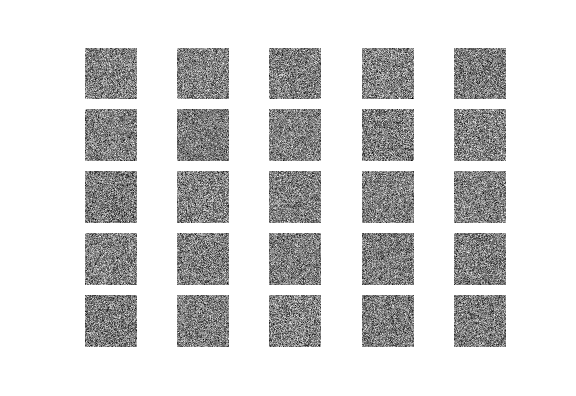

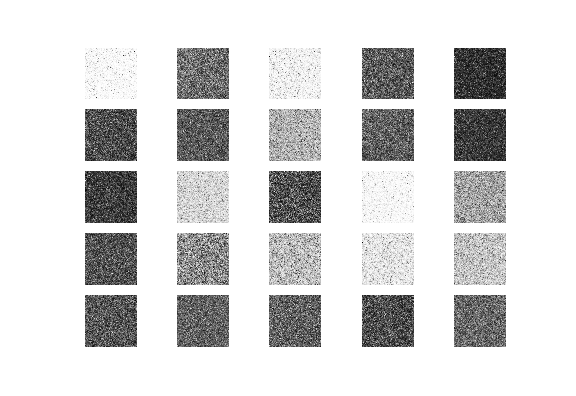

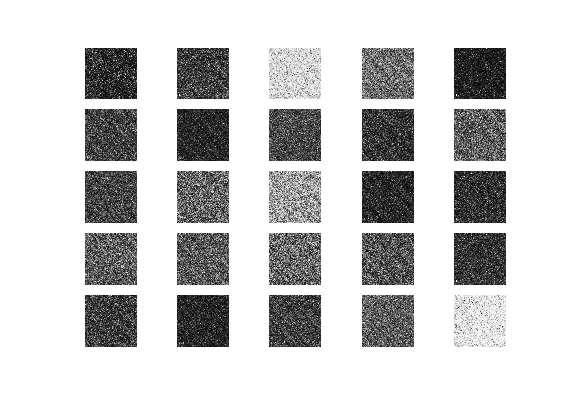

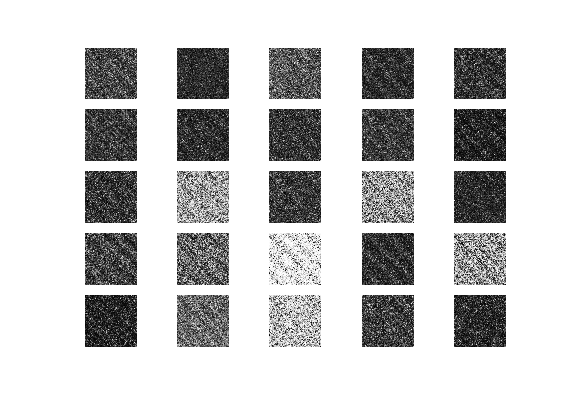

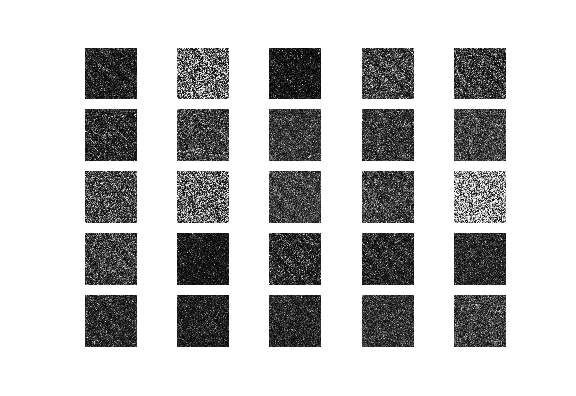

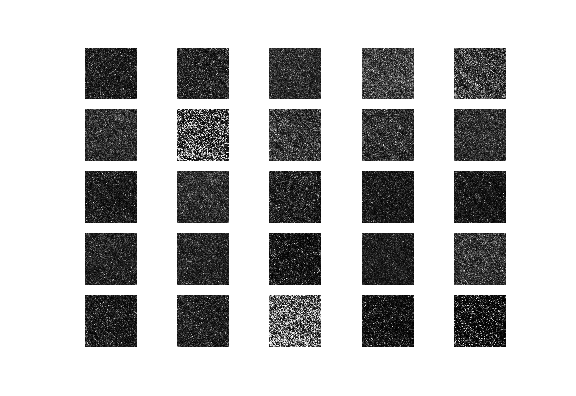

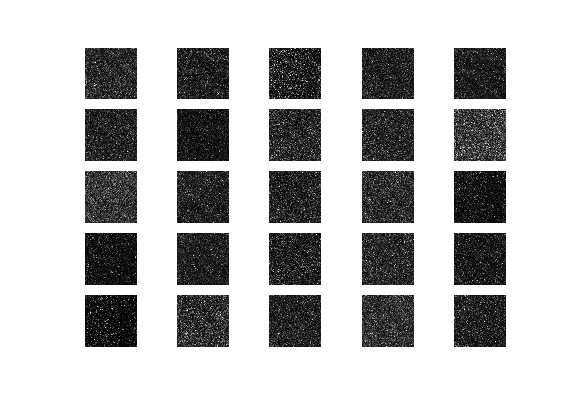

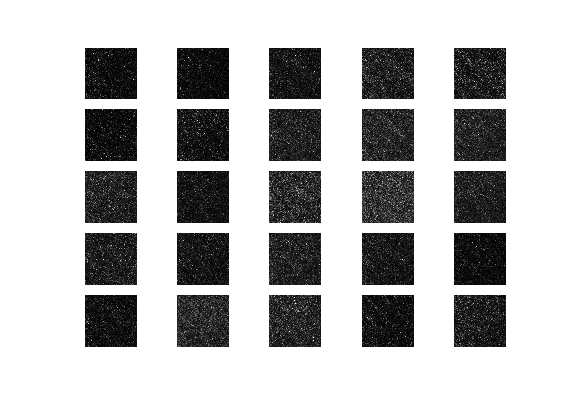

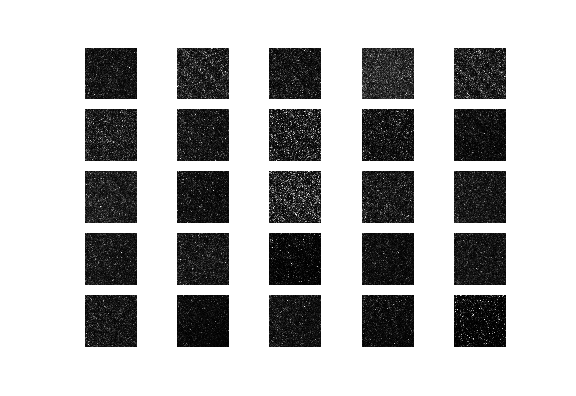

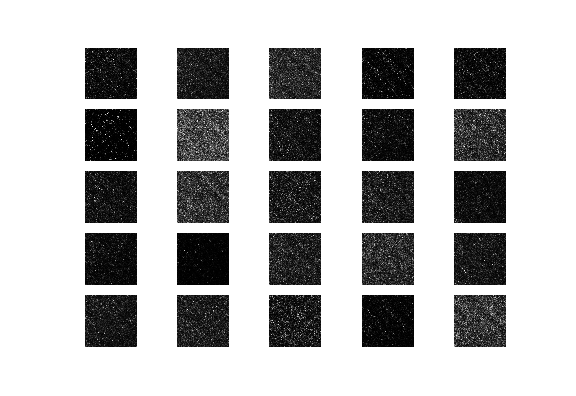

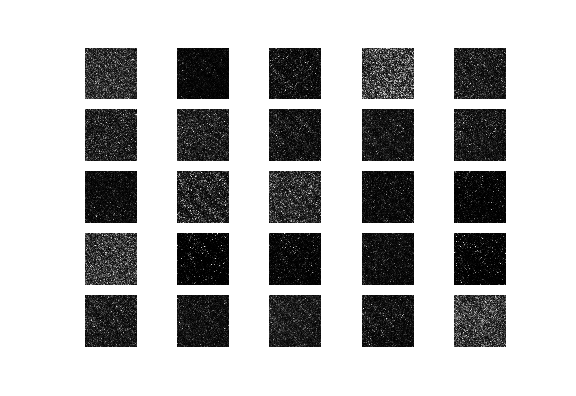

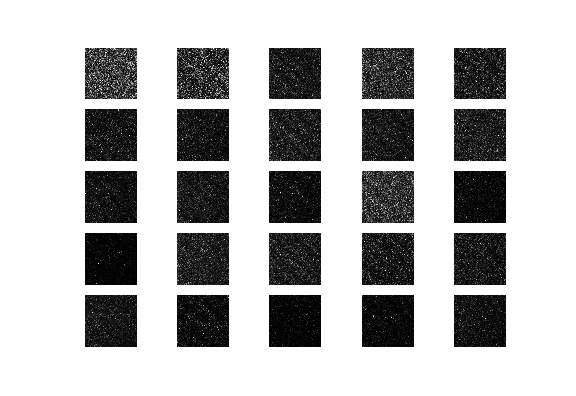

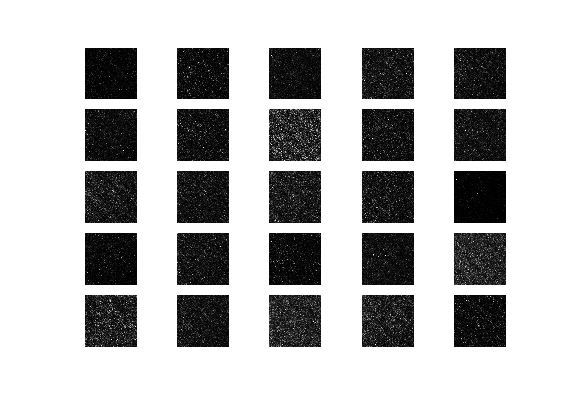

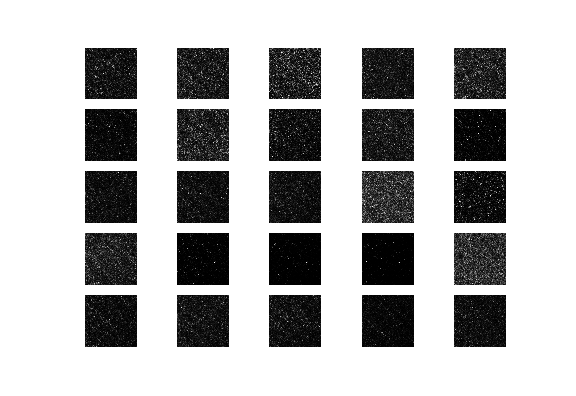

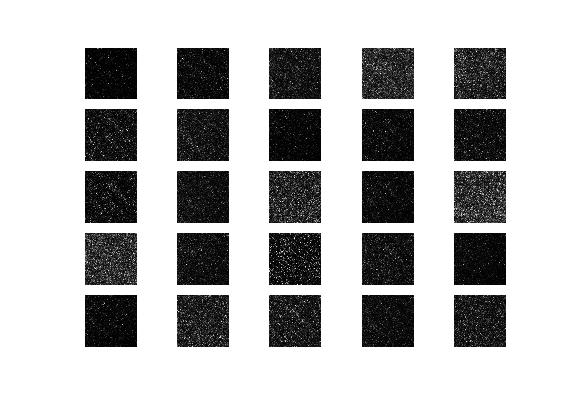

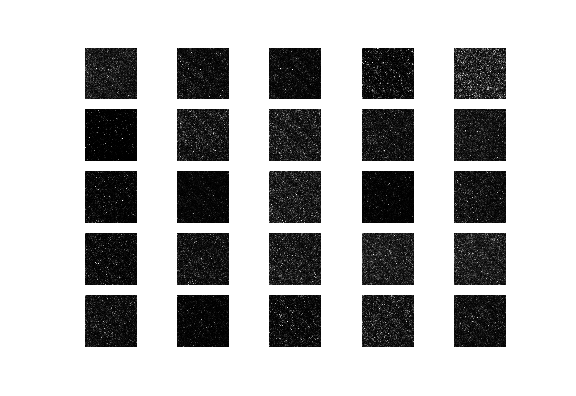

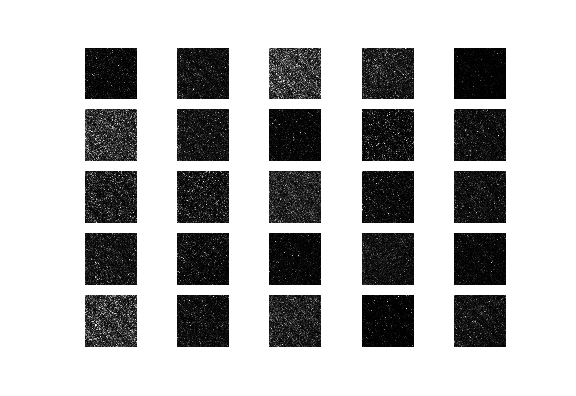

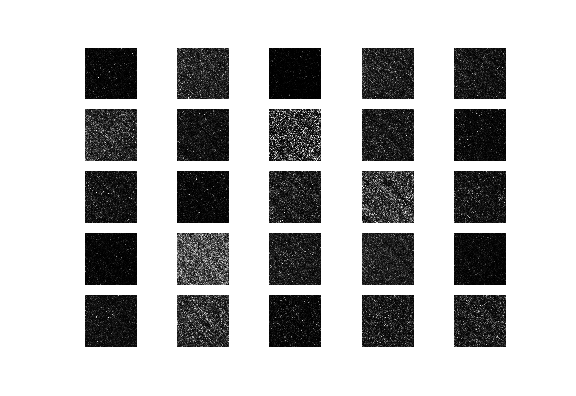

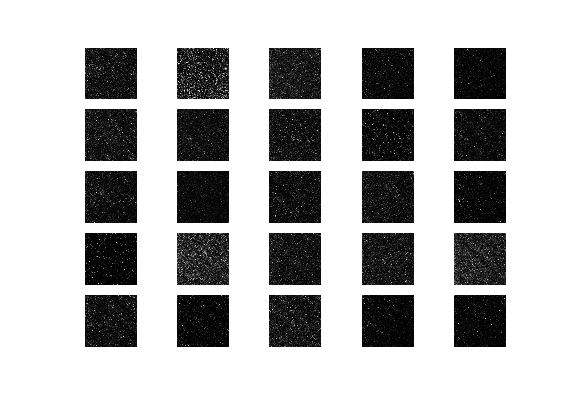

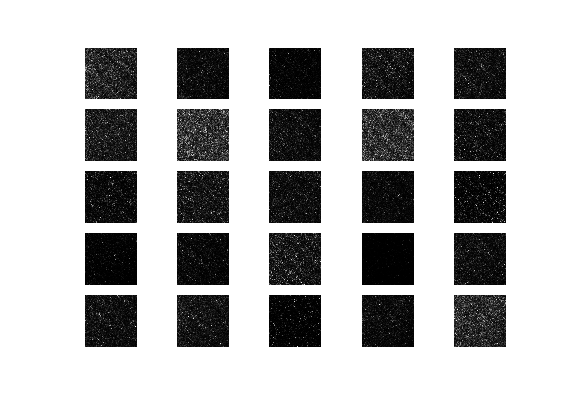

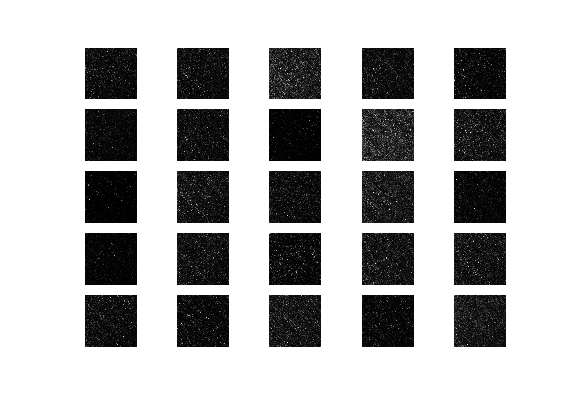

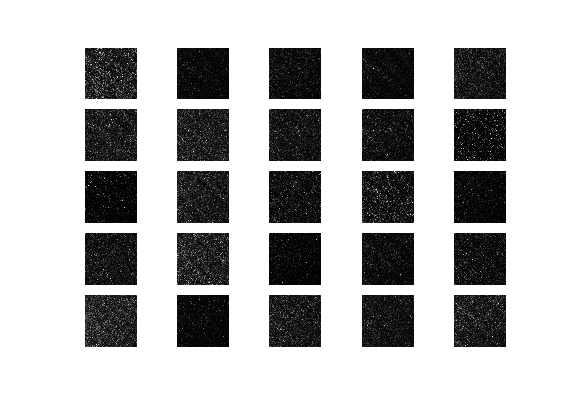

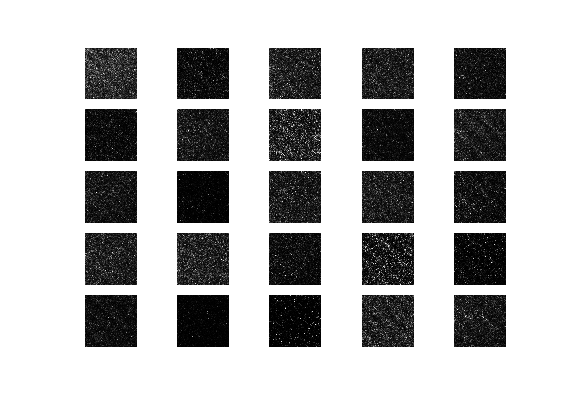

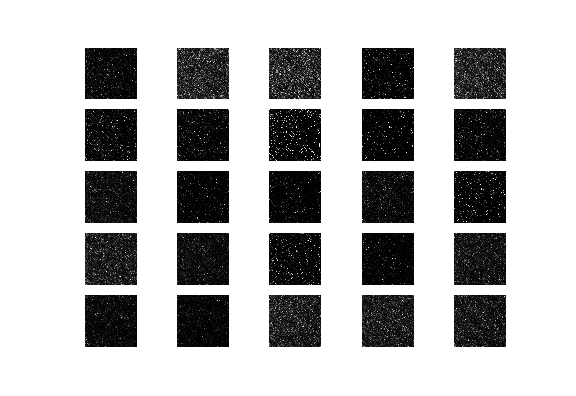

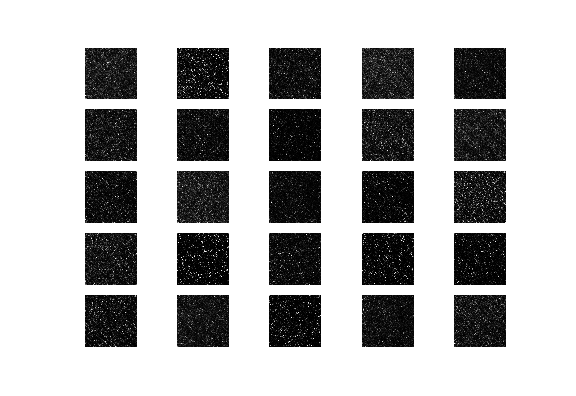

In [4]:
from IPython.display import Image, display
for i in range(0, 5000, 200):
  display(Image('result/%d.png' % i))